In [141]:
# allow imports from the LM package
import os
import sys
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt

## Data arrived from the Initial concentration model 
The below dataset is from the initial concentration model with the diffusion coefficient and initial concentration set as:
$C_0$ = 50
D = 200

In [142]:
def C_x_t(x,t,theta):
    D,C0 = theta
    return C0/np.sqrt(4 * np.pi * D * t) * np.exp(- x**2/(4 * D * t))

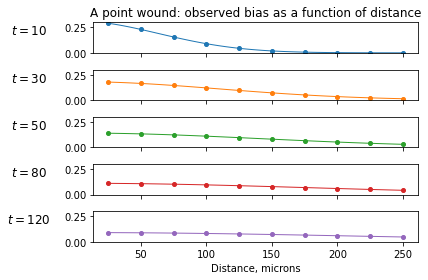

In [143]:

fig, axes = plt.subplots(ncols=1, nrows=5, sharex=True)
    
# where to measure observed bias
r_points = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250])#, 175, 200, 225, 250
r = np.linspace(25, 250, 100)
t = np.array([10, 30, 50, 80, 120])

for ax, p in zip(axes, t):
    ax.set_ylabel('$t={}$'.format(p), rotation=0, size='large', labelpad=35)

# plot the points 
lines = []
scatters = []
for i, tt in enumerate(t):
    col = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    lines.append(axes[i].plot(r, C_x_t(r, tt, [200,50]), color=col, linewidth=1)[0])
    scatters.append(axes[i].plot(r_points, C_x_t(r_points, tt, [200,50]), color=col, marker='o', linewidth=0, markersize=4)[0])
    axes[i].set_ylim(0, 0.3)

axes[0].set_title('A point wound: observed bias as a function of distance')
axes[-1].set_xlabel('Distance, microns')
plt.tight_layout()

In [144]:
from scipy.stats import halfnorm,uniform,multivariate_normal
np.random.seed(500)
ob_readings = {}
for T, ob in zip(t, scatters):
    mus = ob.get_ydata()
    rs = ob.get_xdata()
    for r, mu in zip(rs, mus):
        ob_readings[(r, T)] = (mu, halfnorm.rvs(0.02,0.05))
        


This script: inference.attractant_inference_TEST_prod only calls the production time model and ignores the initial concentration model, to test whether there is an issue when choosing between the two models  

In [145]:
from inference.attractant_inference_TEST_PT import AttractantInfererProd
nwalkers = 100
niters = 5000

In [146]:
inferer_prod= AttractantInfererProd(ob_readings, t_units='minutes')


In [12]:
out_prod = inferer_prod.ensembleinfer(nwalkers,niters)

  0%|          | 2/5000 [00:00<04:10, 19.99it/s]

Running sampler: 


100%|██████████| 5000/5000 [03:04<00:00, 27.15it/s]


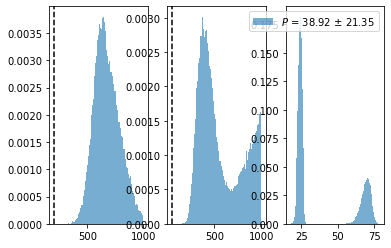

In [17]:
D,C0 = 200,50

p = out_prod[0].get_chain(discard=500, thin=5, flat=True)
Ds1 = p[:,0]
C0s1 = p[:,1]
tau = p[:,2]
fig,axes = plt.subplots(ncols=3, nrows=1)

axes[0].hist(Ds1,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(Ds1), np.std(Ds1)),bins=100,alpha=0.6,density=True)
axes[0].axvline(D,color='black',ls='--', label = f"True value: {D}")
axes[1].hist(C0s1,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(C0s1), np.std(C0s1)),bins=100,alpha=0.6,density=True)
axes[1].axvline(C0,color='black',ls='--', label = f"True value: {C0}")
axes[2].hist(tau,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(tau), np.std(tau)),bins=100,alpha=0.6,density=True)
plt.legend()

In [18]:
p[0,:]

array([735.93752254, 565.00938347,  25.94260982])

This script: inference.attractant_inference_TEST only calls the initial concentration model and ignores the initial concentration model, to test whether there is an issue when choosing between the two models 

In [19]:
from inference.attractant_inference_TEST_IC import AttractantInferer
nwalkers = 100
niters = 5000
inferer_init = AttractantInferer(ob_readings, t_units='minutes')



In [20]:
out_init = inferer_init.ensembleinfer(nwalkers,niters)

  0%|          | 4/5000 [00:00<02:34, 32.37it/s]

Running sampler: 


100%|██████████| 5000/5000 [01:55<00:00, 43.25it/s]


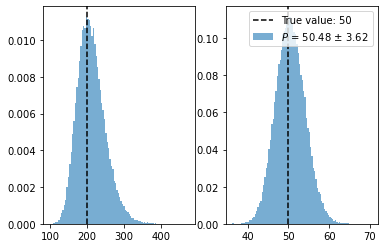

In [23]:
D,C0 = 200,50

ps = out_init[0].get_chain(discard=500, thin=5, flat=True)
Ds = ps[:,0]
C0s = ps[:,1]
fig,axes = plt.subplots(ncols=2, nrows=1)

axes[0].hist(Ds,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(Ds), np.std(Ds)),bins=100,alpha=0.6,density=True)
axes[0].axvline(D,color='black',ls='--', label = f"True value: {D}")
axes[1].hist(C0s,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(C0s), np.std(C0s)),bins=100,alpha=0.6,density=True)
axes[1].axvline(C0,color='black',ls='--', label = f"True value: {C0}")
plt.legend()

In [26]:
def HME(sampler,n_discards):
    log_probs = sampler.get_log_prob(flat = True,discard = n_discards) #(n_iterations,n_walkers)
    probs = np.exp(log_probs)
    HME = 1 / np.mean(1/probs)
    return HME

HME1 = HME(out_prod[0],500)
HME2 = HME(out_init[0],500)

In [27]:
HME1/HME2

6.394836559837455e-12

## Data derived from the production time model 
The below dataset is from the production time model with the diffusion coefficient and initial concentration set as:

$q$ = 500

D = 500

$\tau$ = 28

In [80]:
from scipy.special import expi

def C_prod(r,t,theta):
    q,D,tau = theta
    factor = q / (4 * np.pi * D)


    if t < tau:
        out = -expi(- r ** 2 / (4 * D * t))
    else:
        out = expi(- r ** 2 / (4 * D * (t - tau))) - expi(- r ** 2 / (4 * D * t))
    
    return factor * out


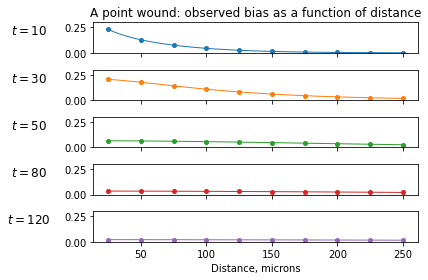

In [85]:
fig, axes = plt.subplots(ncols=1, nrows=5, sharex=True)
    
# where to measure observed bias
r_points = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250])#, 175, 200, 225, 250
r = np.linspace(25, 250, 100)
t = np.array([10, 30, 50, 80, 120])

for ax, p in zip(axes, t):
    ax.set_ylabel('$t={}$'.format(p), rotation=0, size='large', labelpad=35)

# plot the points 
lines_p = []
scatters = []
for i, tt in enumerate(t):
    col = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    lines_p.append(axes[i].plot(r, C_prod(r, tt, [500,500,28]), color=col, linewidth=1))
    scatters.append(axes[i].plot(r_points, C_prod(r_points, tt, [500,500,28]), color=col, marker='o', linewidth=0, markersize=4)[0])

    axes[i].set_ylim(0, 0.3)

axes[0].set_title('A point wound: observed bias as a function of distance')
axes[-1].set_xlabel('Distance, microns')
plt.tight_layout()

In [140]:
np.random.seed(500)
ob_readings_prod = {}
for T, ob in zip(t, scatters):
    mus = ob.get_ydata()
    rs = ob.get_xdata()
    for r, mu in zip(rs, mus):
        ob_readings_prod[(r, T)] = (mu, halfnorm.rvs(0.02,0.05))
        


In [88]:
inferer_prod_test_2= AttractantInfererProd(ob_readings, t_units='minutes')
out_prod_2 = inferer_prod_test_2.ensembleinfer(nwalkers,niters)


  0%|          | 3/5000 [00:00<03:32, 23.47it/s]

Running sampler: 


100%|██████████| 5000/5000 [03:00<00:00, 27.66it/s]


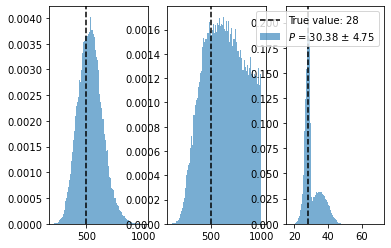

In [94]:
q,D,tau = 500,500,28

p = out_prod_2[0].get_chain(discard=1000, thin=5, flat=True)
Ds1 = p[:,0]
C0s1 = p[:,1]
taus = p[:,2]
fig,axes = plt.subplots(ncols=3, nrows=1)

axes[0].hist(Ds1,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(Ds1), np.std(Ds1)),bins=100,alpha=0.6,density=True)
axes[0].axvline(q,color='black',ls='--', label = f"True value: {D}")
axes[1].hist(C0s1,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(C0s1), np.std(C0s1)),bins=100,alpha=0.6,density=True)
axes[1].axvline(D,color='black',ls='--', label = f"True value: {C0}")
axes[2].hist(taus,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(taus), np.std(taus)),bins=100,alpha=0.6,density=True)
axes[2].axvline(tau,color='black',ls='--', label = f"True value: {tau}")



plt.legend()

In [95]:
print("PT mean acceptance rate is: {0:1.2f}".format(np.mean(out_prod_2[0].acceptance_fraction)))

PT mean acceptance rate is: 0.53


In [96]:
nwalkers = 100
niters = 5000
inferer_init_test_2 = AttractantInferer(ob_readings, t_units='minutes')
out_init_2 = inferer_init_test_2.ensembleinfer(nwalkers,niters)




  0%|          | 4/5000 [00:00<02:25, 34.34it/s]

Running sampler: 


100%|██████████| 5000/5000 [02:03<00:00, 40.47it/s]


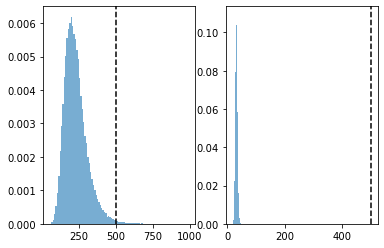

In [98]:
q,D,tau = 500,500,28

p = out_init_2[0].get_chain(discard=1000, thin=5, flat=True)
Ds1 = p[:,0]
C0s1 = p[:,1]
fig,axes = plt.subplots(ncols=2, nrows=1)

axes[0].hist(Ds1,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(Ds1), np.std(Ds1)),bins=100,alpha=0.6,density=True)
axes[0].axvline(q,color='black',ls='--', label = f"True value: {D}")
axes[1].hist(C0s1,label='$P$ = {:.2f} $\pm$ {:.2f}'.format(np.mean(C0s1), np.std(C0s1)),bins=100,alpha=0.6,density=True)
axes[1].axvline(D,color='black',ls='--', label = f"True value: {C0}")

In [103]:
def HME(sampler,n_discards):
    log_probs = sampler.get_log_prob(flat = True,discard = n_discards) #(n_iterations,n_walkers)
    probs = np.exp(log_probs)
    HME = 1 / np.mean(1/probs)
    return HME

HME1 = HME(out_prod_2[0],1000)
HME2 = HME(out_init_2[0],1000)

print("The evidence to support model 1 over model 2: {:.2f}".format(HME1/HME2))

The evidence to support model 1 over model 2: 493.36


In [137]:
def check_hme_print(init_model,prod_model):
    data_from_init_prod = init_model[0]
    data_from_init_init = init_model[1]
    data_from_prod_prod = prod_model[0]
    data_from_prod_init = prod_model[1]
    
    HME1_init = HME(data_from_init_prod[0],1000)
    HME2_init = HME(data_from_init_init[0],1000)
    
    HME1_prod = HME(data_from_prod_prod[0],1000)
    HME2_prod = HME(data_from_prod_init[0],1000)
    
    BF_init = HME1_init/HME2_init
    BF_prod = HME1_prod/HME2_prod
    statement = print("Bayes Factors\n-------------\nModel 1 = Production time\nModel 2 = Initial concentration\nData derived from IC model| BF = {:.2E}|Model 2 is favoured\nData derived from PT model| BF = {:.2f}| Model 1 is favoured".format(BF_init,BF_prod))
    return statement

In [138]:
check_hme_print([out_prod,out_init],[out_prod_2,out_init_2])

Bayes Factors
-------------
Model 1 = Production time
Model 2 = Initial concentration
Data derived from IC model| BF = 6.65E-12|Model 2 is favoured
Data derived from PT model| BF = 493.36| Model 1 is favoured
